In [1]:
from codecarbon import EmissionsTracker
import logging
output_directory = "/fp/homes01/u01/ec-krimhau/thesis_code/"

tracker = EmissionsTracker(output_dir=output_directory)
tracker.start()

[codecarbon INFO @ 08:29:24] [setup] RAM Tracking...
[codecarbon INFO @ 08:29:24] [setup] GPU Tracking...
[codecarbon INFO @ 08:29:24] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 08:29:24] [setup] CPU Tracking...
[codecarbon WARNING @ 08:29:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 08:29:27] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 08:29:27] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 08:29:27] >>> Tracker's metadata:
[codecarbon INFO @ 08:29:27]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 08:29:27]   Python version: 3.11.3
[codecarbon INFO @ 08:29:27]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 08:29:27]   Available RAM : 256.000 GB
[codecarbon INFO @ 08:29:27]   CPU count: 24
[codecarbon INFO @ 08:29:27]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

In [2]:
logging.getLogger('codecarbon').setLevel(logging.WARNING)

In [3]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

import wandb
# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# Load .env file
%load_ext dotenv
%dotenv /fp/homes01/u01/ec-krimhau/thesis_code/.env

In [5]:
os.environ['WANDB_NOTEBOOK_NAME'] = '/fp/homes01/u01/ec-krimhau/thesis_code/jira/priority_model/highest_vs_rest/deberta/01_training/01_train_highest_vs_rest.ipynb'
# Get wandb api key from .env file
wandb_api_key = os.getenv('WANDB_API_KEY')
# Login to wandb to track results
wandb.login(key = wandb_api_key) # API key

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /fp/homes01/u01/ec-krimhau/thesis_code/jira/priority_model/highest_vs_rest/deberta/01_training/01_train_highest_vs_rest.ipynb.
wandb: Currently logged in as: haugerud-kristian (krimhau). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /fp/homes01/u01/ec-krimhau/.netrc


True

In [6]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = id_generator(size=12)
print(HASH_NAME)


773gzdz1vvus


In [7]:
CONFIG = {"seed": 42,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [8]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [9]:
def train_test_split(df, train_percent=.85, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [10]:
full_training_df = pd.read_csv("../../csv/highest_vs_rest_balanced_jira.csv" , index_col = 0)
full_training_df


,text_clean,label,class_original
class,,,
highest,when we do range query on simple keys it does ...,1,Highest
highest,unhandledpromiserejectionwarning unhandled pro...,1,Highest
rest,the fabricunittestdaily branch failing intermi...,0,Medium
rest,as a system operator i want to receive alerts ...,0,Medium
rest,there is no support in datasourcetransactionma...,0,Medium
...,...,...,...
rest,once i have imported a widget into the store i...,0,Low
rest,the spec defines an axiom of a ie singleton li...,0,Medium
rest,to have an history on master of all csvs setup...,0,Medium


In [11]:

# Drop NaN values and reset index of dataframe
full_training_df = full_training_df[full_training_df['text_clean'].notna()]
full_training_df = full_training_df.rename(columns={'text_clean': 'text'})
full_training_df = full_training_df.reset_index()
full_training_df.drop(columns=["class", "class_original"], inplace=True)

In [12]:
full_training_df

,text,label
0,when we do range query on simple keys it does ...,1
1,unhandledpromiserejectionwarning unhandled pro...,1
2,the fabricunittestdaily branch failing intermi...,0
3,as a system operator i want to receive alerts ...,0
4,there is no support in datasourcetransactionma...,0
...,...,...
110711,once i have imported a widget into the store i...,0
110712,the spec defines an axiom of a ie singleton li...,0
110713,to have an history on master of all csvs setup...,0
110714,there are still some changes expected to be me...,1


In [13]:
import pandas as pd
fine_tuning_df = pd.read_csv("../../csv/github_clean_flutter_testset.csv")
fine_tuning_df


,text_clean,label
0,breaks flutterplugins ci since the release of ...,1
1,some rollers are not triggering all the builde...,1
2,flutter web crashes when moving between two sc...,0
3,windows gradlepluginlightapktest is flaky meta...,1
4,transform widget not working correctly with im...,0
...,...,...
2365,engine roller blocked on ciyaml validation fai...,1
2366,whether the customscrollview can save the scro...,1
2367,all pr try jobs infra failed i dont see any lo...,1
2368,linux frameworktestslibraries is flaky metatag...,1


In [14]:

fine_tuning_df = fine_tuning_df.rename(columns={'text_clean': 'text'})
fine_tuning_df

,text,label
0,breaks flutterplugins ci since the release of ...,1
1,some rollers are not triggering all the builde...,1
2,flutter web crashes when moving between two sc...,0
3,windows gradlepluginlightapktest is flaky meta...,1
4,transform widget not working correctly with im...,0
...,...,...
2365,engine roller blocked on ciyaml validation fai...,1
2366,whether the customscrollview can save the scro...,1
2367,all pr try jobs infra failed i dont see any lo...,1
2368,linux frameworktestslibraries is flaky metatag...,1


In [15]:
# Split the full training dataframe into training and test dataframes
# 85/15 split. Validation set will be created from the training set later.
train_full_training_df, test_full_training_df = train_test_split(full_training_df)


In [16]:
# Split the fine-tuning data frame into training and test data frames
# Where 30% of the data is used for training and 70% for testing
fine_tune_train_df , fine_tune_test_df = train_test_split(fine_tuning_df, train_percent=.30) # 30%

In [17]:
fine_tune_train_df

,text,label
1094,hot restart breaks keyboard input steps to rep...,1
188,no output after signing in using phoneauth fir...,0
1800,defining plural strings without space between ...,0
707,large regression in defs sync time due to and ...,1
679,fling causes nestedscrollview inner and outer ...,0
...,...,...
2028,test performance has regressed caused by cc ch...,0
1811,regression in test case for previously fixed r...,1
1883,review request for revert pr pull request was ...,1
1750,dart fix hangs on windows after dart roll on e...,1


In [18]:
# Concatenate the training dataframes into the final training dataframe
df = pd.concat([train_full_training_df, fine_tune_train_df], ignore_index = True)

In [19]:
df

,text,label
0,currently we are using usrshareelasticsearch a...,0
1,its been over hrs since the mirror has been up...,0
2,there has been discussion on the mailing lists...,0
3,when elytron client tries to obtain clientconf...,1
4,need to be able to release all items at once v...,1
...,...,...
94814,test performance has regressed caused by cc ch...,0
94815,regression in test case for previously fixed r...,1
94816,review request for revert pr pull request was ...,1
94817,dart fix hangs on windows after dart roll on e...,1


In [20]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [21]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      1        15866
       0        15741
1      0        15821
       1        15785
2      0        15813
       1        15793
Name: count, dtype: int64

In [22]:
df

,text,label,kfold
0,currently we are using usrshareelasticsearch a...,0,2
1,its been over hrs since the mirror has been up...,0,0
2,there has been discussion on the mailing lists...,0,0
3,when elytron client tries to obtain clientconf...,1,1
4,need to be able to release all items at once v...,1,0
...,...,...,...
94814,test performance has regressed caused by cc ch...,0,0
94815,regression in test case for previously fixed r...,1,0
94816,review request for revert pr pull request was ...,1,1
94817,dart fix hangs on windows after dart roll on e...,1,2


In [23]:
class HP_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [24]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [25]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [26]:
class HP_Model(nn.Module):
    def __init__(self, model_name):
        super(HP_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [27]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [28]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [30]:
def all_classification_report(y_true, y_pred, target_names = ['Non_HP', 'HP'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_HP', 'HP'])
    ax.yaxis.set_ticklabels(['Non_HP', 'HP'])
    
    return  accuracy , f1score
    
    

In [31]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [32]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [33]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = HP_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = HP_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [34]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

====== Fold: 0 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 1976/1976 [04:15<00:00,  7.73it/s, Epoch=1, LR=9.16e-6, Valid_Loss=0.596]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6333    0.7597    0.6908     15741
          HP     0.7027    0.5635    0.6255     15866

    accuracy                         0.6612     31607
   macro avg     0.6680    0.6616    0.6581     31607
weighted avg     0.6682    0.6612    0.6580     31607

Accuracy = 0.6612
F1_score = 0.6255
Validation Loss Improved (inf ---> 0.5964535737865905)
Model Saved



100%|██████████| 1976/1976 [04:15<00:00,  7.73it/s, Epoch=2, LR=6.94e-6, Valid_Loss=0.583]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7554    0.5716    0.6508     15741
          HP     0.6576    0.8164    0.7285     15866

    accuracy                         0.6945     31607
   macro avg     0.7065    0.6940    0.6896     31607
weighted avg     0.7063    0.6945    0.6898     31607

Accuracy = 0.6945
F1_score = 0.7285
Validation Loss Improved (0.5964535737865905 ---> 0.5829970947128731)
Model Saved



100%|██████████| 1976/1976 [04:15<00:00,  7.72it/s, Epoch=3, LR=4.19e-6, Valid_Loss=0.593]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7242    0.6632    0.6923     15741
          HP     0.6916    0.7494    0.7193     15866

    accuracy                         0.7065     31607
   macro avg     0.7079    0.7063    0.7058     31607
weighted avg     0.7078    0.7065    0.7059     31607

Accuracy = 0.7065
F1_score = 0.7193

Training complete in 1h 43m 48s
Best Loss: 0.5830


Train Loss,█▄▁
Valid Accuracy,▁▆█
Valid F1_score,▁█▇
Valid Loss,█▁▆
Best Loss,0.583
Train Loss,0.51091
Valid Accuracy,0.7065
Valid F1_score,0.7193
Valid Loss,0.59301



====== Fold: 1 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 1976/1976 [04:23<00:00,  7.51it/s, Epoch=1, LR=9.16e-6, Valid_Loss=0.596]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7630    0.5455    0.6361     15821
          HP     0.6457    0.8302    0.7264     15785

    accuracy                         0.6877     31606
   macro avg     0.7043    0.6878    0.6813     31606
weighted avg     0.7044    0.6877    0.6812     31606

Accuracy = 0.6877
F1_score = 0.7264
Validation Loss Improved (inf ---> 0.595780841043944)
Model Saved



100%|██████████| 1976/1976 [04:23<00:00,  7.51it/s, Epoch=2, LR=6.94e-6, Valid_Loss=0.575]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7744    0.5486    0.6422     15821
          HP     0.6499    0.8398    0.7327     15785

    accuracy                         0.6940     31606
   macro avg     0.7121    0.6942    0.6875     31606
weighted avg     0.7122    0.6940    0.6874     31606

Accuracy = 0.694
F1_score = 0.7327
Validation Loss Improved (0.595780841043944 ---> 0.5752559776099613)
Model Saved



100%|██████████| 1976/1976 [04:22<00:00,  7.52it/s, Epoch=3, LR=4.19e-6, Valid_Loss=0.565]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6906    0.7585    0.7230     15821
          HP     0.7315    0.6595    0.6936     15785

    accuracy                         0.7090     31606
   macro avg     0.7111    0.7090    0.7083     31606
weighted avg     0.7111    0.7090    0.7083     31606

Accuracy = 0.709
F1_score = 0.6936
Validation Loss Improved (0.5752559776099613 ---> 0.5645457851896556)
Model Saved

Training complete in 1h 44m 45s
Best Loss: 0.5645


Train Loss,█▄▁
Valid Accuracy,▁▃█
Valid F1_score,▇█▁
Valid Loss,█▃▁
Best Loss,0.56455
Train Loss,0.51834
Valid Accuracy,0.709
Valid F1_score,0.6936
Valid Loss,0.56455



====== Fold: 2 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 1976/1976 [04:23<00:00,  7.50it/s, Epoch=1, LR=9.16e-6, Valid_Loss=0.576]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7255    0.6215    0.6695     15813
          HP     0.6686    0.7645    0.7133     15793

    accuracy                         0.6930     31606
   macro avg     0.6970    0.6930    0.6914     31606
weighted avg     0.6970    0.6930    0.6914     31606

Accuracy = 0.693
F1_score = 0.7133
Validation Loss Improved (inf ---> 0.5756259487677486)
Model Saved



100%|██████████| 1976/1976 [04:23<00:00,  7.49it/s, Epoch=2, LR=6.94e-6, Valid_Loss=0.569]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6810    0.7501    0.7139     15813
          HP     0.7215    0.6483    0.6829     15793

    accuracy                         0.6992     31606
   macro avg     0.7013    0.6992    0.6984     31606
weighted avg     0.7013    0.6992    0.6984     31606

Accuracy = 0.6992
F1_score = 0.6829
Validation Loss Improved (0.5756259487677486 ---> 0.5692272904143185)
Model Saved



100%|██████████| 1976/1976 [04:23<00:00,  7.51it/s, Epoch=3, LR=4.19e-6, Valid_Loss=0.566]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7322    0.6474    0.6872     15813
          HP     0.6836    0.7629    0.7211     15793

    accuracy                         0.7051     31606
   macro avg     0.7079    0.7052    0.7041     31606
weighted avg     0.7079    0.7051    0.7041     31606

Accuracy = 0.7051
F1_score = 0.7211
Validation Loss Improved (0.5692272904143185 ---> 0.5660009133306959)
Model Saved

Training complete in 1h 44m 22s
Best Loss: 0.5660


Train Loss,█▄▁
Valid Accuracy,▁▅█
Valid F1_score,▇▁█
Valid Loss,█▃▁
Best Loss,0.566
Train Loss,0.51013
Valid Accuracy,0.7051
Valid F1_score,0.7211
Valid Loss,0.566


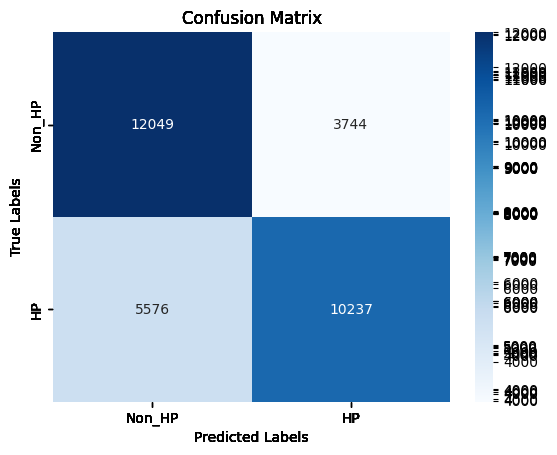

In [35]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='HP_results_Jira_High_vs_rest_results', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=[CONFIG['model_name'], f'{HASH_NAME}'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = HP_Model(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

<h2> Testing Inference </h2>


In [36]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [37]:
test_df = fine_tune_test_df

In [38]:
test_df

,text,label
483,flutter app doesnt switch to dark theme in deb...,0
2004,add usecase class to camerax plugin in the cam...,0
277,linuxandroidviewscrollperftimelinesummary fail...,1
1552,flutter drive should take a directory name as ...,0
221,add a swiftshader vulkan backend to the playgr...,0
...,...,...
1638,causes oom iskakaushik is assigned to the upst...,1
1095,rename app to flutter gallery gallery is too g...,0
1130,unhelpful error message when xcode requires ad...,0
1294,support doubletapdrag on text fields on androi...,0


In [39]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [40]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = HP_Model(CONFIG['model_name'])

In [41]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [42]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [43]:
# Change the HASH_NAME according to new generated hash for your run
#HASH_NAME = "ekgx4wmexn91"


In [44]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 104/104 [00:18<00:00,  5.70it/s]


Fold 1


100%|██████████| 104/104 [00:17<00:00,  5.79it/s]


Fold 2


100%|██████████| 104/104 [00:17<00:00,  5.79it/s]


In [45]:
deberta_predictions


[array([[0.7659737 , 0.23402637],
        [0.84599686, 0.1540031 ],
        [0.393755  , 0.606245  ],
        ...,
        [0.77629375, 0.22370625],
        [0.94023246, 0.0597676 ],
        [0.8872611 , 0.11273897]], dtype=float32),
 array([[0.87342966, 0.12657034],
        [0.94338715, 0.05661286],
        [0.45083737, 0.5491626 ],
        ...,
        [0.94161636, 0.0583836 ],
        [0.97326535, 0.02673464],
        [0.87195325, 0.12804674]], dtype=float32),
 array([[0.96906775, 0.03093231],
        [0.8545568 , 0.14544317],
        [0.6477759 , 0.35222408],
        ...,
        [0.9130884 , 0.0869116 ],
        [0.9744135 , 0.02558653],
        [0.9788493 , 0.02115076]], dtype=float32)]

In [46]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.8694904 , 0.13050967],
       [0.8813136 , 0.11868638],
       [0.49745607, 0.5025439 ],
       ...,
       [0.87699944, 0.12300048],
       [0.9626371 , 0.03736292],
       [0.91268796, 0.08731216]], dtype=float32)

In [47]:
len(predictions)

1659

In [48]:
predictions

array([[0.8694904 , 0.13050967],
       [0.8813136 , 0.11868638],
       [0.49745607, 0.5025439 ],
       ...,
       [0.87699944, 0.12300048],
       [0.9626371 , 0.03736292],
       [0.91268796, 0.08731216]], dtype=float32)

In [49]:
test_df["prediction_0"] = predictions[:, 0] 

In [50]:
test_df["prediction_1"] = predictions[:, 1] 

In [51]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [52]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
483,flutter app doesnt switch to dark theme in deb...,0,0.869490,0.130510,0,0,0
2004,add usecase class to camerax plugin in the cam...,0,0.881314,0.118686,0,0,0
277,linuxandroidviewscrollperftimelinesummary fail...,1,0.497456,0.502544,1,1,0
1552,flutter drive should take a directory name as ...,0,0.901749,0.098251,0,0,0
221,add a swiftshader vulkan backend to the playgr...,0,0.648343,0.351657,0,0,0
...,...,...,...,...,...,...,...
1638,causes oom iskakaushik is assigned to the upst...,1,0.348095,0.651905,1,1,1
1095,rename app to flutter gallery gallery is too g...,0,0.945274,0.054726,0,0,0
1130,unhelpful error message when xcode requires ad...,0,0.876999,0.123000,0,0,0
1294,support doubletapdrag on text fields on androi...,0,0.962637,0.037363,0,0,0


In [53]:
len(test_df)

1659

In [54]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [55]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [56]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [57]:
test_df["pred"] = test_df["pred"].astype(int)

In [58]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
483,flutter app doesnt switch to dark theme in deb...,0,0.869490,0.130510,0,0,0,prediction_0,0
2004,add usecase class to camerax plugin in the cam...,0,0.881314,0.118686,0,0,0,prediction_0,0
277,linuxandroidviewscrollperftimelinesummary fail...,1,0.497456,0.502544,1,1,0,prediction_1,1
1552,flutter drive should take a directory name as ...,0,0.901749,0.098251,0,0,0,prediction_0,0
221,add a swiftshader vulkan backend to the playgr...,0,0.648343,0.351657,0,0,0,prediction_0,0
...,...,...,...,...,...,...,...,...,...
1638,causes oom iskakaushik is assigned to the upst...,1,0.348095,0.651905,1,1,1,prediction_1,1
1095,rename app to flutter gallery gallery is too g...,0,0.945274,0.054726,0,0,0,prediction_0,0
1130,unhelpful error message when xcode requires ad...,0,0.876999,0.123000,0,0,0,prediction_0,0
1294,support doubletapdrag on text fields on androi...,0,0.962637,0.037363,0,0,0,prediction_0,0


In [59]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[649 185]
 [143 682]]


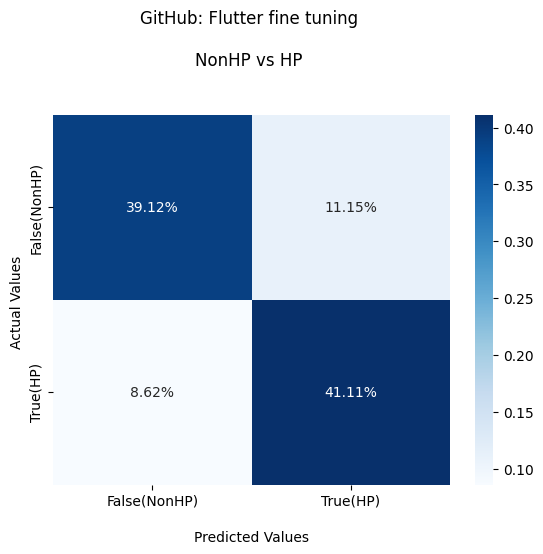

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('GitHub: Flutter fine tuning \n\nNonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [61]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       834
           1       0.79      0.83      0.81       825

    accuracy                           0.80      1659
   macro avg       0.80      0.80      0.80      1659
weighted avg       0.80      0.80      0.80      1659



In [62]:
test_df[["text","label","pred"]].to_csv("Flutter_70_Test_inference.csv")

In [63]:
from sklearn.metrics import matthews_corrcoef

# Calculate the Matthew's Correlation Coefficient
mcc = matthews_corrcoef(test_df["label"].values, test_df["pred"].values)
print("Matthew's Correlation Coefficient:", mcc)

Matthew's Correlation Coefficient: 0.6054542421365642


In [64]:
tracker.stop()

0.0487283642962494